<a href="https://colab.research.google.com/github/finardi/tutos/blob/master/Clustering_KMEANS_with_BERT.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
! pip install -q transformers

     |████████████████████████████████| 2.2MB 15.4MB/s 
     |████████████████████████████████| 870kB 67.6MB/s 
     |████████████████████████████████| 3.3MB 71.0MB/s 


In [2]:
from transformers import BertModel, BertTokenizer

from sklearn.cluster import KMeans
import torch
import pandas as pd

In [3]:
text_list = [
        'arroz com feijão e batata frita|1001',
        'arroz salada e mandioca|1010',
        'arroz com feijão e abobrinha|1101',
        'arroz com feijão batata frit|1001',
        'feijão arroz e cenoura|1011',
        'beterraba, chuchu e arroz com feijão|1111',
        'arroz com milho e feijão com couve|2001',
        'batata frita com legumes e soja|2010',
        'arroz com bata frita|2010',
        'madioquinha com sopa de feijão|2010',
        'arroz feijo e batata fita|1001',
        'mesa, cadeira e escrivaninha|2711',
        'cadeira, mesa e escrivaninha|2711',
        'escrivaninha, mesa e cadeira|2711',
        'geladeira e fogão|1711',
        'microondas e geraleira|1711',
        'geladeira e mesa azul|1711',
        'roupeiro, criado-mudo e cama|2804',
        'criado-mudo e cama|2804',
        'roupeiro e criado-mudo|2804',
        'cama e roupeiro|2804',
        'microondas e cama|2805',
        'mochila e roupeiro|2805',
        'ps1, ps2, ps3, ps4 e ps5|1311',
        'n64, snes, ps3, ps4 e ps5|1211',
        'ps1, ps2, n64, ps4 e ps5|1341',
        'ps5, ps4, ps3, ps2 e ps1|1311',
        'ps1, n64, snes, switch|2311',
        'ps6, ps7, ps8, ps9 e ps10|3211',
        'ps10, ps2, ps3, ps4 e ps5|3211',
        'mega-drive, nes, snes|1301',
        'mega drive, n64, snes|1301',
        'megadrive, nes, n64|1301',
        'mega-drive, snes, nes|1311',
        'mega drive, nes, n64|1311',
        'tom, planck, ozzy, mel, nina, pingado e gisele|0000',
        'tom, planck, ozzy, mel, nina, pingado gisele|0000',
        'paulo, tom, planck, ozzy, mel, nina, pingado e gisele|0001',
        'paulo, eli, tom, planck, ozzy, mel, nina, pingado e gisele|0001',
        'jan, paulo, eli, tom, planck, ozzy, mel, nina, pingado e gisele|0001',
]

mydict = {}
for i, item in enumerate(text_list):
    mydict[i] = item.split('|')[0], item.split('|')[1]

df = pd.DataFrame(mydict).T
df = df.rename(columns={0:'text', 1:'doc'})

# BERTaú - Embeddings

In [4]:
%%time

def get_embs(text_list:[], path_model:str):
    tokenizer = BertTokenizer.from_pretrained(path_model)
    model = BertModel.from_pretrained(path_model)
    hidden_size = model.config.hidden_size
    embs = torch.zeros(len(df)*hidden_size).reshape(len(df), hidden_size)

    for i, text in enumerate(text_list):
        tokens = tokenizer(text, return_tensors='pt')
        outs = model(**tokens, return_dict=True)
        last_hidden_state = outs['last_hidden_state']
        # cls = last_hidden_state[:,0, :].squeeze(0).detach().numpy()
        
        # without CLS and SEP
        embs_mean = torch.einsum("ijk -> k", last_hidden_state[:,1:-1,])#.detach().numpy()
        embs[i] = embs_mean

    return embs
# --------------------------------------------------
path_model = 'Itau-Unibanco/BERTau'
embeddings = get_embs(df.text.to_list(), path_model)


CPU times: user 13.4 s, sys: 1.48 s, total: 14.8 s
Wall time: 24.3 s


# K-Means

In [5]:
# Perform kmean clustering
num_clusters = 8
clustering_model = KMeans(n_clusters=num_clusters)
clustering_model.fit(embeddings.detach().numpy())
cluster_assignment = clustering_model.labels_

clustered_sentences = [[] for i in range(num_clusters)]
for sentence_id, cluster_id in enumerate(cluster_assignment):
    clustered_sentences[cluster_id].append(df.text.to_list()[sentence_id])

for i, cluster in enumerate(clustered_sentences):
    print("Cluster ", i+1)
    print(cluster)
    print("")

Cluster  1
['arroz com feijão e batata frita', 'arroz com feijão e abobrinha', 'arroz com feijão batata frit', 'arroz com milho e feijão com couve', 'batata frita com legumes e soja', 'madioquinha com sopa de feijão']

Cluster  2
['paulo, eli, tom, planck, ozzy, mel, nina, pingado e gisele', 'jan, paulo, eli, tom, planck, ozzy, mel, nina, pingado e gisele']

Cluster  3
['ps1, ps2, ps3, ps4 e ps5', 'n64, snes, ps3, ps4 e ps5', 'ps1, ps2, n64, ps4 e ps5', 'ps5, ps4, ps3, ps2 e ps1', 'ps6, ps7, ps8, ps9 e ps10', 'ps10, ps2, ps3, ps4 e ps5']

Cluster  4
['feijão arroz e cenoura', 'arroz com bata frita', 'geladeira e fogão', 'microondas e geraleira', 'geladeira e mesa azul', 'criado-mudo e cama', 'cama e roupeiro', 'microondas e cama', 'mochila e roupeiro']

Cluster  5
['tom, planck, ozzy, mel, nina, pingado e gisele', 'tom, planck, ozzy, mel, nina, pingado gisele', 'paulo, tom, planck, ozzy, mel, nina, pingado e gisele']

Cluster  6
['ps1, n64, snes, switch', 'mega-drive, nes, snes', 'mega

# Agglomerative

In [6]:
from sklearn.cluster import AgglomerativeClustering
import numpy as np

In [7]:
# Normalize the embeddings to unit length
embeddings_ = embeddings.detach().numpy() /  np.linalg.norm(embeddings.detach().numpy(), axis=1, keepdims=True)

# Perform kmean clustering

#, affinity='cosine', linkage='average', distance_threshold=0.4)
clustering_model = AgglomerativeClustering(n_clusters=None, distance_threshold=.8) 
clustering_model.fit(embeddings_)
cluster_assignment = clustering_model.labels_

clustered_sentences = {}
for sentence_id, cluster_id in enumerate(cluster_assignment):
    if cluster_id not in clustered_sentences:
        clustered_sentences[cluster_id] = []

    clustered_sentences[cluster_id].append(df.text.to_list()[sentence_id])

for i, cluster in clustered_sentences.items():
    print("Cluster ", i+1)
    print(cluster)
    print("")

Cluster  3
['arroz com feijão e batata frita', 'arroz com feijão e abobrinha', 'arroz com feijão batata frit', 'feijão arroz e cenoura', 'beterraba, chuchu e arroz com feijão', 'arroz com milho e feijão com couve', 'batata frita com legumes e soja', 'arroz com bata frita', 'madioquinha com sopa de feijão', 'arroz feijo e batata fita']

Cluster  2
['arroz salada e mandioca', 'mesa, cadeira e escrivaninha', 'cadeira, mesa e escrivaninha', 'escrivaninha, mesa e cadeira']

Cluster  4
['geladeira e fogão', 'geladeira e mesa azul', 'microondas e cama']

Cluster  1
['microondas e geraleira', 'roupeiro, criado-mudo e cama', 'criado-mudo e cama', 'roupeiro e criado-mudo', 'cama e roupeiro', 'mochila e roupeiro']

Cluster  6
['ps1, ps2, ps3, ps4 e ps5', 'ps1, ps2, n64, ps4 e ps5', 'ps5, ps4, ps3, ps2 e ps1', 'ps6, ps7, ps8, ps9 e ps10', 'ps10, ps2, ps3, ps4 e ps5']

Cluster  5
['n64, snes, ps3, ps4 e ps5', 'ps1, n64, snes, switch', 'mega-drive, nes, snes', 'mega drive, n64, snes', 'megadrive, ne

# BERTaú Topic

In [33]:
! pip install -q umap-learn
! pip install -q hdbscan

In [ ]:
import umap
import hdbscan
import matplotlib.pyplot as plt

In [12]:
umap_embeddings = umap.UMAP(n_neighbors=15, 
                            n_components=5, 
                            metric='cosine').fit_transform(embeddings.detach().numpy())

In [13]:
cluster = hdbscan.HDBSCAN(min_cluster_size=15,
                          metric='euclidean',                      
                          cluster_selection_method='eom').fit(umap_embeddings)

In [24]:
# Prepare data
umap_data = umap.UMAP(n_neighbors=5, n_components=2, min_dist=0.0, metric='cosine').fit_transform(embeddings.detach().numpy())
result = pd.DataFrame(umap_data, columns=['x', 'y'])
result['labels'] = cluster.labels_

result

,x,y,labels
0,11.557990,-2.539973,0
1,13.007361,-0.930544,0
2,12.174338,-2.865076,0
3,11.949113,-2.228929,0
4,11.551455,-2.850513,0
5,12.887666,-1.389477,0
6,12.258449,-2.385958,0
7,11.513174,-2.070125,0
8,11.715192,-2.410806,0
9,11.934608,-2.904753,0


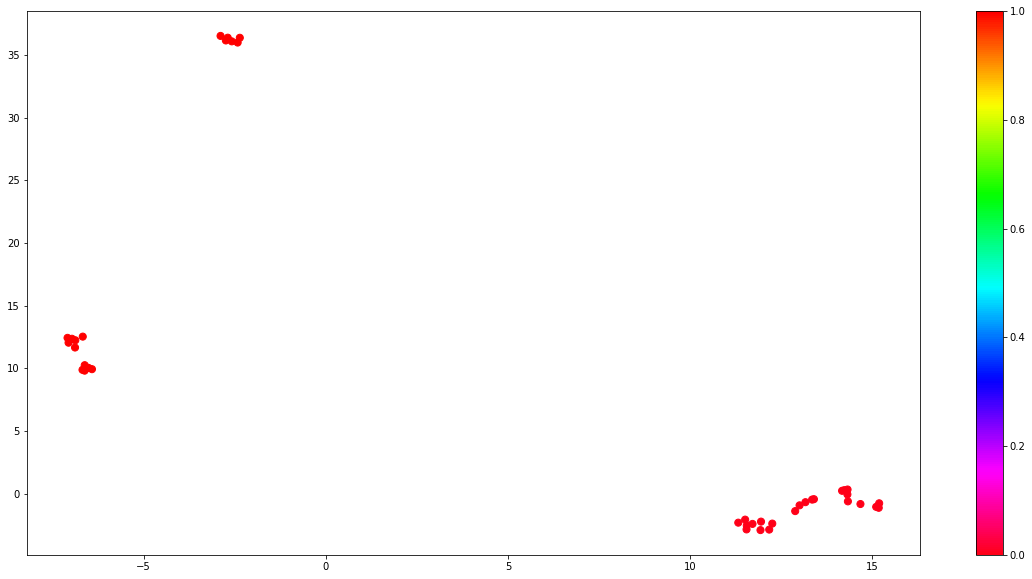

In [31]:
# Visualize clusters
fig, ax = plt.subplots(figsize=(20, 10))
outliers = result.loc[result.labels == -1, :]
clustered = result.loc[result.labels != -1, :]
plt.scatter(outliers.x, outliers.y, color='#BDBDBD', s=0.05)
plt.scatter(clustered.x, clustered.y, c=clustered.labels, s=50, cmap='hsv_r')
plt.colorbar()

In [ ]:
# see https://towardsdatascience.com/topic-modeling-with-bert-779f7db187e6

docs_df = pd.DataFrame(data, columns=["doc"])
docs_df['Topic'] = cluster.labels_
docs_df['Doc_ID'] = range(len(docs_df))
docs_per_topic = docs_df.groupby(['Topic'], as_index = False).agg({'Doc': ' '.join})